# CRISP‑DM (Classification)
This Colab notebook walks through **all phases of CRISP‑DM** .


## 1) Business Understanding
**Goal:** Predict whether a customer will churn next month so retention team can prioritize outreach.

**Success criteria (SMART):**

- **Model**: ROC‑AUC ≥ 0.83; Recall ≥ 0.75 at ≤ 0.35 FPR.

- **Business**: Identify top 20% high‑risk customers to reduce churn by ≥ 5% in the next quarter.

**Constraints/Assumptions:** One‑month horizon; features are from billing/CRM tables.



## 2) Data Understanding
**Dataset:** IBM Telco Customer Churn (CSV). Public mirror URL below.

**Target:** `Churn` (Yes/No)

**High‑level questions:** schema, missingness, leakage, class balance, drift risk.



In [1]:

# === Setup
!pip -q install pandas numpy scikit-learn matplotlib gradio==4.44.0 --quiet

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# Load data (IBM public mirror; also available on Kaggle)
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print(df.shape)
df.head(3)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 6.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-adk 1.17.0 requires websockets<16.0.0,>=15.0.1, but you have websockets 12.0 which is incompatible.
yfinance 0.2.66 requires websockets>=13.0, but you have websockets 12.0 which is incompatible.
dataproc-spark-connect 0.8.3 requires websockets>=14.0, but you have websockets 12.0 which is incompatible.
google-genai 1.46.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 12.0 which is incompatible.
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
customerID,7043,7043,3186-AJIEK,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,7043,2,Male,3555,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7043.0,NaN,NaN,NaN,0.162147,0.368612,0.0,0.0,0.0,0.0,1.0
Partner,7043,2,No,3641,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7043,2,No,4933,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7043.0,NaN,NaN,NaN,32.371149,24.559481,0.0,9.0,29.0,55.0,72.0
PhoneService,7043,2,Yes,6361,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7043,3,No,3390,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7043,3,Fiber optic,3096,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7043,3,No,3498,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Positive rate: 0.2654


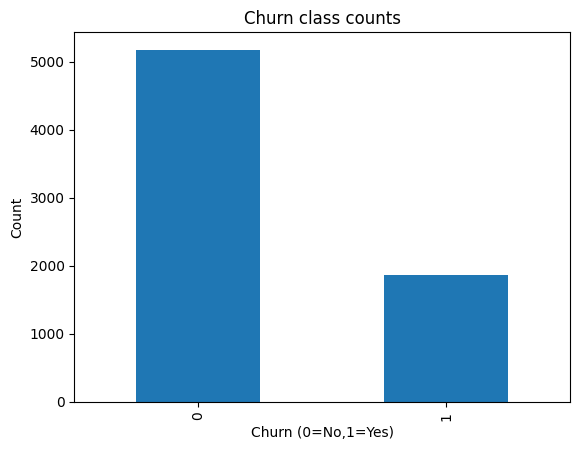

In [2]:

# Basic info
df.info()
display(df.describe(include='all').T.head(20))

# Target distribution
target = df['Churn'].map({'Yes':1,'No':0})
print('Positive rate:', target.mean().round(4))

# Quick plots (Colab will show output); no style/colors specified by default
plt.figure()
target.value_counts().sort_index().plot(kind='bar')
plt.title('Churn class counts')
plt.xlabel('Churn (0=No,1=Yes)')
plt.ylabel('Count')
plt.show()


In [3]:

# Data quality checks
missing = df.isna().mean().sort_values(ascending=False)
print('Missingness (top 20)')
print(missing.head(20))

# Known issue: 'TotalCharges' is object due to spaces -> coerce to numeric
df['TotalCharges_num'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print('Coerced TotalCharges missing:', df['TotalCharges_num'].isna().sum())


Missingness (top 20)
customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
dtype: float64
Coerced TotalCharges missing: 11


## 3) Data Preparation
Steps: impute/clean, encode categoricals, split, scale where needed, and persist artifacts.

We'll use a scikit‑learn `ColumnTransformer` + `Pipeline` to keep prep tied to the model (reproducible).



In [4]:

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Clean obvious issues
df_prep = df.copy()
df_prep['TotalCharges'] = pd.to_numeric(df_prep['TotalCharges'], errors='coerce')

# Drop customerID (identifier) and the original TotalCharges text column once numeric fixed
y = df_prep['Churn'].map({'Yes':1, 'No':0}).astype(int)
X = df_prep.drop(columns=['Churn','customerID'])

numeric_feats = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, numeric_feats),
        ('cat', categorical_pipe, categorical_feats)
    ]
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

len(numeric_feats), len(categorical_feats), X_train.shape, X_test.shape


(5, 15, (5282, 20), (1761, 20))

## 4) Modeling
We try **Logistic Regression**, **RandomForest**, and **XGBoost‑like** alternative (HistGradientBoosting) to avoid extra installs.

We use cross‑validated hyperparameter search and track ROC‑AUC, PR‑AUC, and Recall@FPR.




Logistic Regression — best ROC‑AUC: 0.846, AP: 0.635, Recall@FPR<=0.35: 0.865 @ thr=0.193
Best params: {'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Confusion matrix
 [[843 451]
 [ 63 404]]

Classification report
               precision    recall  f1-score   support

           0      0.930     0.651     0.766      1294
           1      0.473     0.865     0.611       467

    accuracy                          0.708      1761
   macro avg      0.701     0.758     0.689      1761
weighted avg      0.809     0.708     0.725      1761



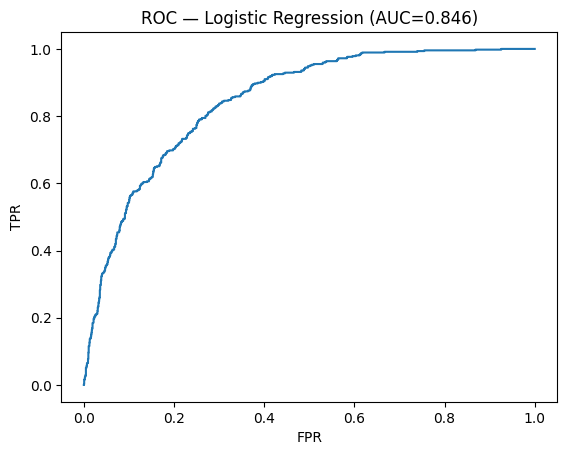


Random Forest — best ROC‑AUC: 0.846, AP: 0.652, Recall@FPR<=0.35: 0.863 @ thr=0.222
Best params: {'clf__max_depth': 6, 'clf__min_samples_leaf': 3, 'clf__n_estimators': 400}
Confusion matrix
 [[845 449]
 [ 64 403]]

Classification report
               precision    recall  f1-score   support

           0      0.930     0.653     0.767      1294
           1      0.473     0.863     0.611       467

    accuracy                          0.709      1761
   macro avg      0.701     0.758     0.689      1761
weighted avg      0.809     0.709     0.726      1761



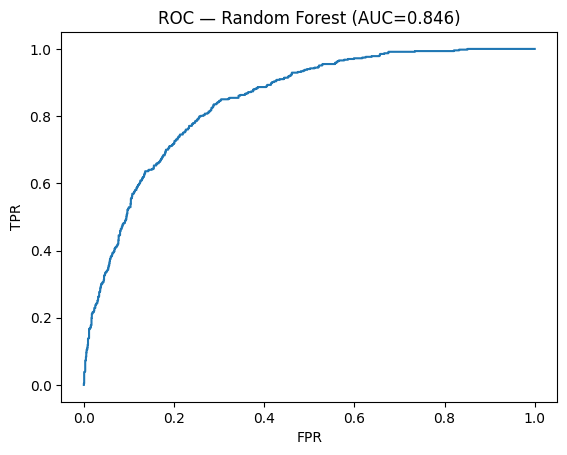


HistGradientBoosting — best ROC‑AUC: 0.848, AP: 0.655, Recall@FPR<=0.35: 0.859 @ thr=0.190
Best params: {'clf__learning_rate': 0.05, 'clf__max_depth': 3}
Confusion matrix
 [[842 452]
 [ 66 401]]

Classification report
               precision    recall  f1-score   support

           0      0.927     0.651     0.765      1294
           1      0.470     0.859     0.608       467

    accuracy                          0.706      1761
   macro avg      0.699     0.755     0.686      1761
weighted avg      0.806     0.706     0.723      1761



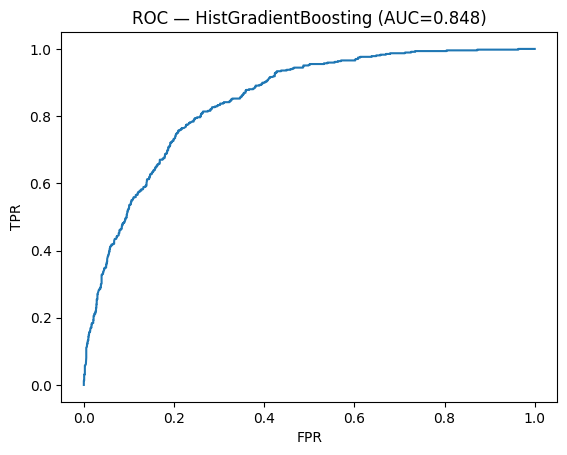

{'LogReg': {'roc_auc': np.float64(0.846367189697798),
  'ap': np.float64(0.6351120669050975),
  'recall_at_fpr<=0.35': np.float64(0.8650963597430407),
  'thr': np.float64(0.1932059464877638)},
 'RandomForest': {'roc_auc': np.float64(0.8457458075320454),
  'ap': np.float64(0.6516754749213582),
  'recall_at_fpr<=0.35': np.float64(0.8629550321199143),
  'thr': np.float64(0.22229220630506752)},
 'HGB': {'roc_auc': np.float64(0.847799430082509),
  'ap': np.float64(0.6553127525053696),
  'recall_at_fpr<=0.35': np.float64(0.8586723768736617),
  'thr': np.float64(0.1900638788202838)}}

In [6]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import numpy as np

def fit_and_eval(model, param_grid, name):
    pipe = Pipeline(steps=[('prep', preprocess),
                           ('clf', model)])
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    search = GridSearchCV(
        pipe, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0
    )
    search.fit(X_train, y_train)
    best = search.best_estimator_
    proba = best.predict_proba(X_test)[:,1]
    roc = roc_auc_score(y_test, proba)
    ap = average_precision_score(y_test, proba)
    fpr, tpr, thr = roc_curve(y_test, proba)
    # Find threshold with FPR <= 0.35 and max recall
    recall_at_fpr = 0; best_thr = 0.5
    for f, t, th in zip(fpr, tpr, thr):
        if f <= 0.35 and t > recall_at_fpr:
            recall_at_fpr = t; best_thr = th
    y_pred = (proba >= best_thr).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    print(f"\n{name} — best ROC‑AUC: {roc:.3f}, AP: {ap:.3f}, Recall@FPR<=0.35: {recall_at_fpr:.3f} @ thr={best_thr:.3f}")
    print('Best params:', search.best_params_)
    print('Confusion matrix\n', cm)
    print('\nClassification report\n', classification_report(y_test, y_pred, digits=3))
    # Basic ROC plot
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f'ROC — {name} (AUC={roc:.3f})')
    plt.xlabel('FPR'); plt.ylabel('TPR')
    plt.show()
    return best, {'roc_auc': roc, 'ap': ap, 'recall_at_fpr<=0.35': recall_at_fpr, 'thr': best_thr}

results = {}

# 4.1 Logistic Regression
lr_model, lr_metrics = fit_and_eval(
    LogisticRegression(max_iter=1000, n_jobs=None),
    {'clf__C':[0.1, 0.5, 1.0, 2.0], 'clf__penalty':['l2'], 'clf__solver':['lbfgs']},
    'Logistic Regression'
)
results['LogReg'] = lr_metrics

# 4.2 RandomForest
rf_model, rf_metrics = fit_and_eval(
    RandomForestClassifier(random_state=42),
    {'clf__n_estimators':[200, 400],
     'clf__max_depth':[None, 6, 12],
     'clf__min_samples_leaf':[1, 3, 5]},
    'Random Forest'
)
results['RandomForest'] = rf_metrics

# 4.3 HistGradientBoosting (XGBoost-like, built‑in)
hgb_model, hgb_metrics = fit_and_eval(
    HistGradientBoostingClassifier(random_state=42),
    {'clf__max_depth':[None, 3, 6], 'clf__learning_rate':[0.05, 0.1, 0.2]},
    'HistGradientBoosting'
)
results['HGB'] = hgb_metrics

results


## 5) Evaluation
Check KPIs against SMART success criteria.
We'll also calibrate probabilities and compute cost‑based utility under hypothetical retention budgets.


Selected best model: HGB {'roc_auc': np.float64(0.847799430082509), 'ap': np.float64(0.6553127525053696), 'recall_at_fpr<=0.35': np.float64(0.8586723768736617), 'thr': np.float64(0.1900638788202838)}
Calibrated ROC‑AUC: 0.849, AP: 0.657
Best threshold by utility: 0.2 Utility: 75475


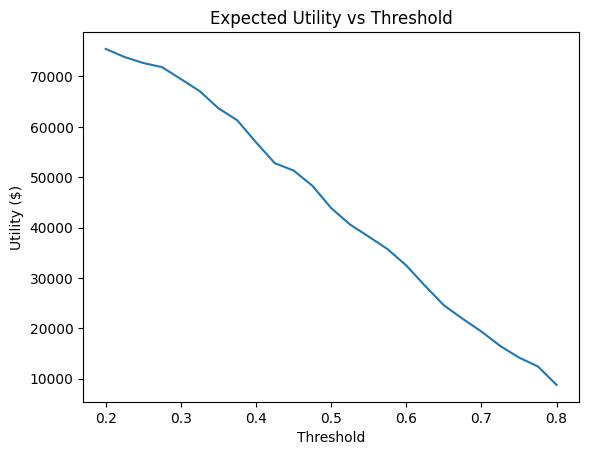

In [7]:

from sklearn.calibration import CalibratedClassifierCV

# Choose the best model from results by ROC-AUC
best_name = max(results, key=lambda k: results[k]['roc_auc'])
best_model = {'LogReg': lr_model, 'RandomForest': rf_model, 'HGB': hgb_model}[best_name]
print('Selected best model:', best_name, results[best_name])

# Probability calibration (Platt)
calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=5)
calibrated.fit(X_train, y_train)
proba = calibrated.predict_proba(X_test)[:,1]

roc = roc_auc_score(y_test, proba)
ap = average_precision_score(y_test, proba)
fpr, tpr, thr = roc_curve(y_test, proba)
print(f'Calibrated ROC‑AUC: {roc:.3f}, AP: {ap:.3f}')

# Cost-based evaluation
# Assume contacting a customer costs $5; preventing a true churn saves $200.
def expected_utility(p, thresh, cost_contact=5, benefit_save=200):
    y_hat = (p>=thresh).astype(int)
    tp = ((y_test==1)&(y_hat==1)).sum()
    fp = ((y_test==0)&(y_hat==1)).sum()
    return tp*benefit_save - (tp+fp)*cost_contact

grid = np.linspace(0.2,0.8,25)
utils = [expected_utility(proba, t) for t in grid]
t_best = grid[int(np.argmax(utils))]
print('Best threshold by utility:', round(float(t_best),3), 'Utility:', int(np.max(utils)))

plt.figure()
plt.plot(grid, utils)
plt.title('Expected Utility vs Threshold')
plt.xlabel('Threshold'); plt.ylabel('Utility ($)')
plt.show()


## 6) Deployment (demo)
We persist the calibrated pipeline with `joblib` and expose a tiny **Gradio** UI for demo predictions.

(For production, wrap this in FastAPI/Cloud Run with model registry + monitoring.)



In [9]:

import joblib, json, gradio as gr

joblib.dump(calibrated, 'telco_churn_calibrated.joblib')
print('Saved model -> telco_churn_calibrated.joblib')

# Build a simple prediction interface
feature_examples = X_test.head(3)
def predict_one(record: dict):
    # record should contain the raw feature names as in X
    X_df = pd.DataFrame([record])
    proba = float(calibrated.predict_proba(X_df)[0,1])
    return {'churn_probability': proba}

inputs = []
for col in X.columns:
    if col in numeric_feats:
        inputs.append(gr.Number(label=col))
    else:
        # For categorical, provide a free text to keep demo simple; in real apps use dropdowns
        inputs.append(gr.Textbox(label=col))

def gr_predict(*vals):
    rec = {col: v for col, v in zip(X.columns, vals)}
    return predict_one(rec)

demo = gr.Interface(
    fn=gr_predict,
    inputs=inputs,
    outputs=[gr.JSON(label="Prediction")],
    title="Telco Churn — Demo Predictor",
    description="Enter feature values to get churn probability."
)

demo.launch()


Saved model -> telco_churn_calibrated.joblib
Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a4b6fd783042cf74be.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
